In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fontMat
import numpy as np
import random

plt.rcParams['font.family']=['SimHei']
plt.rcParams['axes.unicode_minus']=False 

In [120]:
def getDataT(noiseScale,numScale):
    X=np.linspace(0,1,numScale)
    Y=np.sin(2*np.pi*X)+np.random.normal(0,noiseScale,size=numScale) #添加零均值，方差为noiseScale的高斯噪声
    NumData=[]
    for i in range(0,numScale):
        NumData.append([X[i],Y[i]])
    return NumData

In [121]:
def getData(noiseScale,numScale):
    X=np.linspace(0,1,numScale)
    Y=np.sin(2*np.pi*X)+np.random.normal(0,noiseScale,size=numScale) #添加零均值，方差为noiseScale的高斯噪声
    return np.array(X).reshape(numScale,1),np.array(Y).reshape(numScale,1)

In [122]:
def getXMatrix(xData,nScale):
    XMatrix=[]
    for i in range(0,len(xData)):
        XMatrix.append([(lambda j:pow(xData[i],(j-1)))(j)for j in range(1,nScale+1)])
    return np.array(XMatrix)

In [123]:
def getParamWithoutPenalty(XMatrix,TMatrix):
    return np.linalg.inv(XMatrix.T@XMatrix)@XMatrix.T@TMatrix
def getParamWithPenalty(XMatrix,TMatrix,lambdaPenalty):
    return np.linalg.inv(XMatrix.T@XMatrix+lambdaPenalty*np.eye(XMatrix.shape[1],XMatrix.shape[1]))@XMatrix.T@TMatrix

In [124]:
def calcLoss(xMatrix,wVec,tVec,lambdaPenalty):
        return 0.5*np.mean((xMatrix@wVec-tVec).T@(xMatrix@wVec-tVec)+lambdaPenalty*(wVec.T@wVec))

In [125]:
def showSinPlot():
    xData=np.linspace(0,1,150)
    plt.plot(xData,np.sin(2*np.pi*xData),color='black',label="被拟合的正弦曲线")

In [126]:
def showTrainResult(xTrain,yTrain,lineColor,label):
    plt.scatter(xTrain,yTrain,color=lineColor,label=label)

In [127]:
def showPredResult(xData,yPred,lineColor,label):
    plt.plot(xData,yPred,color=lineColor,label=label)

In [128]:
class GradientDescentOptimizer:
    def __init__(self,model,nScale,learningRate,lossLimit,lossFunction):
        self.model=model
        self.nScale=nScale
        self.learningRate=learningRate
        self.lossLimit=lossLimit
        self.lossFunction=lossFunction

    def calcGradient(self,xMatrix,wVec,tVec,lambdaPenalty):
        return xMatrix.T@xMatrix@wVec-xMatrix.T@tVec+lambdaPenalty*wVec
    
    def optimizeParam(self,xMatrix,wVec,tVec,lambdaPenalty):
        # 观测优化过程以及优化次数的限制
        ck=0
        lossArray=[]
        # 记录Loss值
        lastLoss=self.lossFunction(xMatrix,wVec,tVec,lambdaPenalty)
        loss=lastLoss
        while True:
            wVecTmp=wVec-self.learningRate*self.calcGradient(xMatrix,wVec,tVec,lambdaPenalty)
            lossTmp=self.lossFunction(xMatrix,wVecTmp,tVec,lambdaPenalty)
            if lossTmp>lastLoss:
                self.learningRate*=0.5
            else:
                wVec=wVecTmp
                loss=lossTmp
                if(np.abs(loss-lastLoss)<self.lossLimit) and (loss<=1.3 or wVec.shape[0]<=3):
                    break
                lastLoss=loss
                lossArray.append(loss)
            ck+=1
        plt.plot(np.array(lossArray))
        plt.show()
        return wVec,ck


In [129]:
class CGOptimizer:
    def __init__(self, deltaLimit):
        self.deltaLimit = deltaLimit

    def optimizeParam(self, xMatrix, wVec, tVec, lambdaPenalty):
        # Make Data as AX=b
        A = xMatrix.T@xMatrix+lambdaPenalty*np.identity(wVec.shape[0])
        X = wVec
        b = xMatrix.T@tVec

        RLast = b-A@X
        P = RLast
        ck = 0
        while ck < wVec.shape[0]:
            alpha = (P.T@RLast)/(P.T@A@P)
            R = RLast-(alpha*A)@P
            X = X+alpha*P
            if RLast.T@RLast < self.deltaLimit:
                break
            P = R+((R.T@R)/(RLast.T@RLast))*P
            RLast = R
            ck += 1

        return X,ck


In [148]:
# 生成数据参数
NOISE_SCALE = 0.3  # 噪声方差
TRAIN_NUM_SCALE = 20  # 训练集规模
TEST_SCALE = 15  # 测试集规模

NumData=np.random.permutation(getDataT(NOISE_SCALE, TRAIN_NUM_SCALE+TEST_SCALE))
TrainData=np.array(sorted(NumData[0:TRAIN_NUM_SCALE,].reshape(TRAIN_NUM_SCALE,2),key=lambda x:x[0]))
TestData=np.array(sorted(NumData[TRAIN_NUM_SCALE:,].reshape(TEST_SCALE,2),key=lambda x:x[0]))
xTrain=TrainData[0:,0].reshape(TRAIN_NUM_SCALE,1)
yTrain=TrainData[0:,1].reshape(TRAIN_NUM_SCALE,1)
xTest=TestData[0:,0].reshape(TEST_SCALE,1)
yTest=TestData[0:,1].reshape(TEST_SCALE,1)


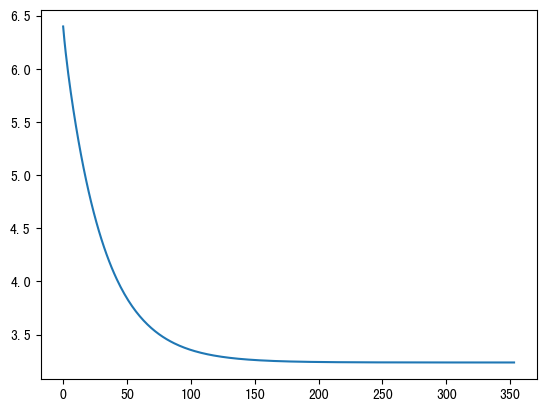

训练集loss= 3.236643370025241
测试集loss= 1.8917694897379562
迭代次数： 2


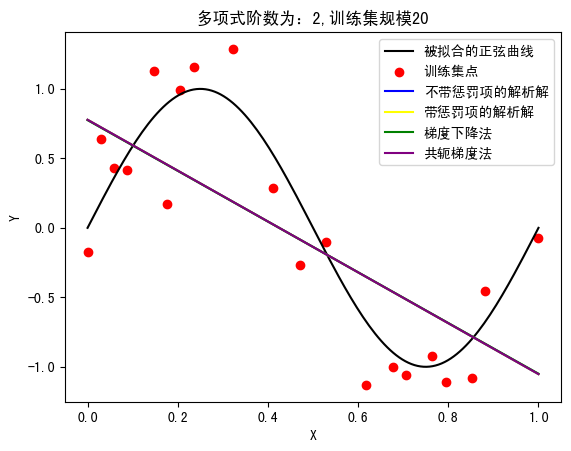

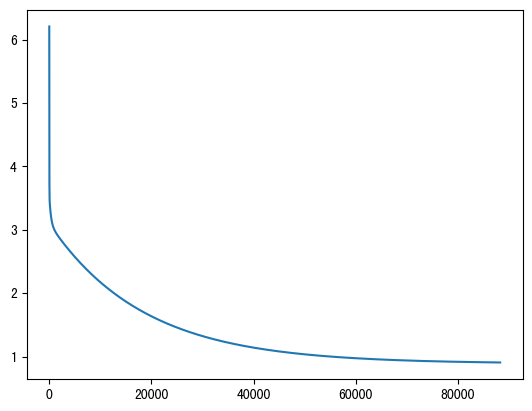

训练集loss= 0.8880775775600902
测试集loss= 0.2658370686605643
迭代次数： 4


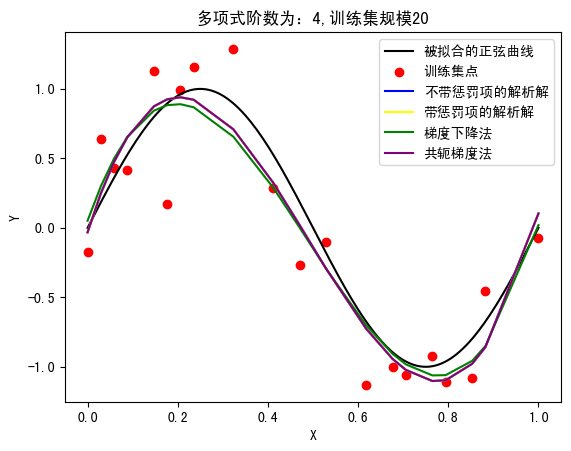

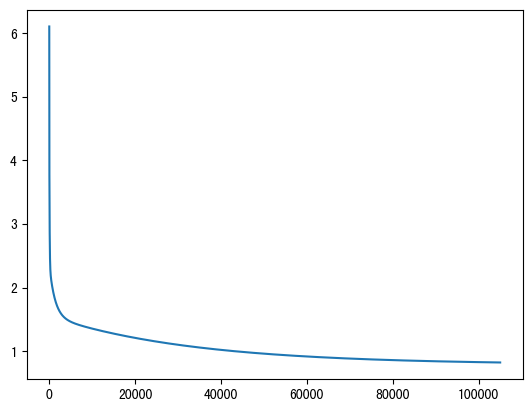

训练集loss= 0.7056185249372322
测试集loss= 0.4636247073410797
迭代次数： 7


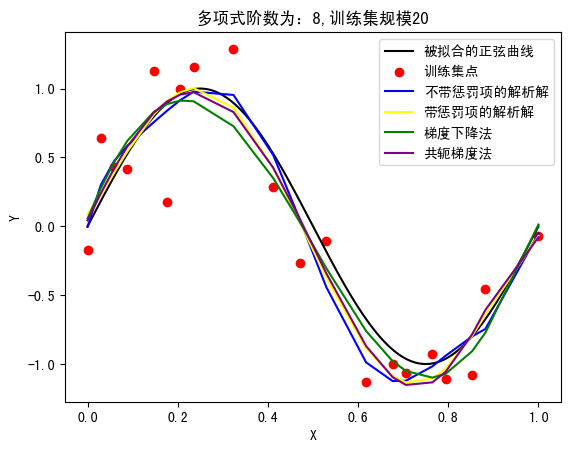

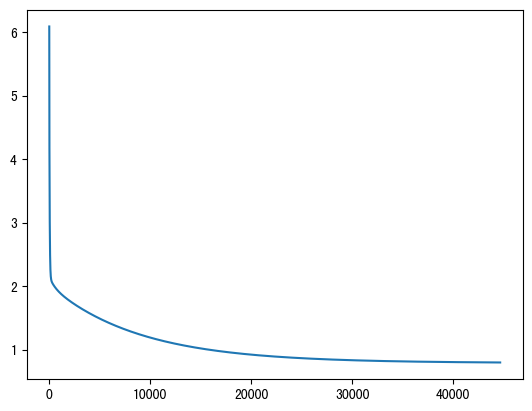

训练集loss= 0.4910385476439779
测试集loss= 15.77650682292741
迭代次数： 7


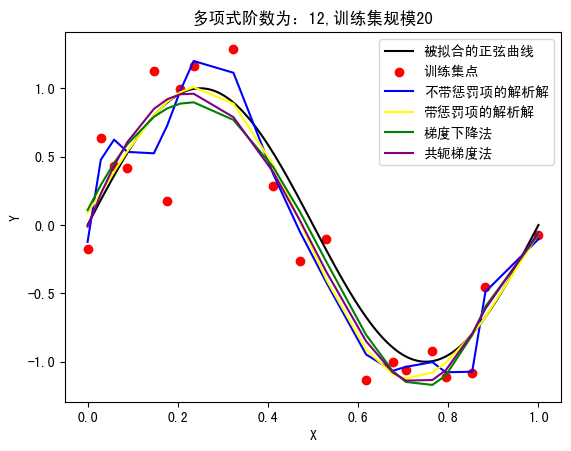

In [161]:
for i in [2,4,8,12]:
    # 训练参数
    N_SCALE = i  # 多项式阶数
    LAMBDA_PENALTY = 1e-7  # 惩罚项系数
    LEARNING_RATE = 0.01  # 学习率
    LOSS_LIMIT = 1e-6  # loss限制

    XTrainMatrix = getXMatrix(xTrain, N_SCALE).reshape(TRAIN_NUM_SCALE, N_SCALE)
    XTestMatrix = getXMatrix(xTest, N_SCALE).reshape(TEST_SCALE, N_SCALE)

    # 解析解方法
    ParamWithoutPenalty = getParamWithoutPenalty(XTrainMatrix, yTrain)
    ParamWithPenalty = getParamWithPenalty(XTrainMatrix, yTrain, LAMBDA_PENALTY)

    # 梯度下降
    wBGD=np.zeros(N_SCALE).reshape(N_SCALE,1)
    optimizer=GradientDescentOptimizer('BGD',N_SCALE,LEARNING_RATE,LOSS_LIMIT,calcLoss)
    wBGD,ck=optimizer.optimizeParam(XTrainMatrix,wBGD,yTrain,LAMBDA_PENALTY)

    # 共轭梯度法
    wCG=np.zeros(N_SCALE).reshape(N_SCALE,1)
    optimizer=CGOptimizer(LOSS_LIMIT)
    wCG,ck=optimizer.optimizeParam(XTrainMatrix,wCG,yTrain,LAMBDA_PENALTY)
    
    print("训练集loss=", calcLoss(XTrainMatrix, ParamWithoutPenalty, yTrain, 0))
    print("测试集loss=", calcLoss(XTestMatrix, ParamWithoutPenalty, yTest, 0))
    print("迭代次数：",ck)
    showSinPlot()
    showTrainResult(xTrain, yTrain, 'red', label="训练集点")
    showPredResult(xTrain, XTrainMatrix@ParamWithoutPenalty,'blue', label='不带惩罚项的解析解')
    showPredResult(xTrain,XTrainMatrix@ParamWithPenalty,'yellow',label="带惩罚项的解析解")
    showPredResult(xTrain,XTrainMatrix@wBGD,'green',label="梯度下降法")
    showPredResult(xTrain,XTrainMatrix@wCG,'purple',label="共轭梯度法")
    plt.title("多项式阶数为："+str(N_SCALE)+",训练集规模"+str(TRAIN_NUM_SCALE))
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()


测试集loss= 0.5386994024734808
测试集loss= 0.547467722270748
测试集loss= 0.5569415469548227
测试集loss= 0.5640613257787783
测试集loss= 0.5691459751718586
测试集loss= 0.5745276519922825
测试集loss= 0.581642166452643
测试集loss= 0.5901199451013737
测试集loss= 0.6010854891707145
测试集loss= 0.6198923551821947
测试集loss= 0.6518182738962907
测试集loss= 0.6909492951284801
测试集loss= 0.7217684144300877
测试集loss= 0.7386301236811342
测试集loss= 0.7463515206872322
测试集loss= 0.7502281675268814
测试集loss= 0.753508966085053
测试集loss= 0.7584292568387105
测试集loss= 0.7661584336746126
测试集loss= 0.7759856990764765
测试集loss= 0.7886024674033753
测试集loss= 0.8111613982677551
测试集loss= 0.8604146656762034
测试集loss= 0.9690186016578797
测试集loss= 1.1808034075407763
测试集loss= 1.489660690445849
测试集loss= 1.7998300026370506
测试集loss= 2.0635018008208483
测试集loss= 2.3630712509197207
测试集loss= 2.846588643855673
[0.5386994  0.54746772 0.55694155 0.56406133 0.56914598 0.57452765
 0.58164217 0.59011995 0.60108549 0.61989236 0.65181827 0.6909493
 0.72176841 0.73863012 0.7463515

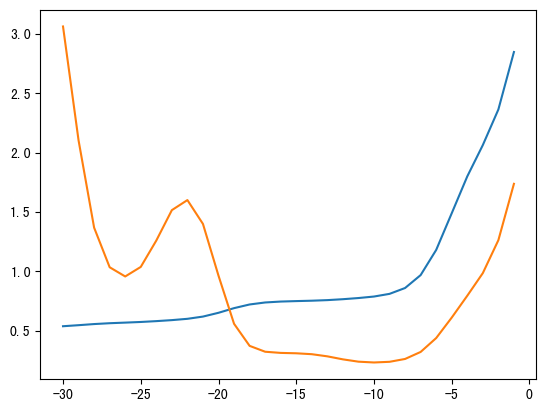

In [149]:
lambdaTrainLoss = []
lambdaTestLoss = []
for j in range(-30, 0):
    # 训练参数
    N_SCALE = 12  # 多项式阶数
    LAMBDA_PENALTY = np.exp(j)  # 惩罚项系数
    LEARNING_RATE = 0.01  # 学习率
    LOSS_LIMIT = 1e-6  # loss限制

    XTrainMatrix = getXMatrix(xTrain, N_SCALE).reshape(TRAIN_NUM_SCALE, N_SCALE)
    XTestMatrix = getXMatrix(xTest, N_SCALE).reshape(TEST_SCALE, N_SCALE)

    # 解析解方法
    paramWithoutPenalty = getParamWithoutPenalty(XTrainMatrix, yTrain)
    ParamWithPenalty = getParamWithPenalty(XTrainMatrix, yTrain, LAMBDA_PENALTY)

    # # 梯度下降
    # wBGD=np.zeros(N_SCALE).reshape(N_SCALE,1)
    # optimizer=GradientDescentOptimizer('BGD',N_SCALE,LEARNING_RATE,LOSS_LIMIT,calcLoss)
    # wBGD,ck=optimizer.optimizeParam(XTrainMatrix,wBGD,yTrain,LAMBDA_PENALTY)

    # # 共轭梯度法
    # wCG=np.zeros(N_SCALE).reshape(N_SCALE,1)
    # optimizer=CGOptimizer(LOSS_LIMIT)
    # wCG,ck=optimizer.optimizeParam(XTrainMatrix,wCG,yTrain,LAMBDA_PENALTY)

    print("测试集loss=", calcLoss(XTrainMatrix,
                               ParamWithPenalty, yTrain, LAMBDA_PENALTY))
    lambdaTrainLoss.append([LAMBDA_PENALTY,calcLoss(XTrainMatrix, ParamWithPenalty, yTrain, LAMBDA_PENALTY)])
    lambdaTestLoss.append([LAMBDA_PENALTY, calcLoss(XTestMatrix, ParamWithPenalty, yTest, LAMBDA_PENALTY)])
    # # print("迭代次数：",ck)
    # showSinPlot()
    # showTrainResult(xTrain, yTrain, 'red', label="训练集点")
    # showPredResult(xTrain, XTrainMatrix@ParamWithPenalty,'blue', label='带惩罚项的解析解')
    # # showPredResult(xTrain,XTrainMatrix@ParamWithPenalty,'yellow',label="带惩罚项的解析解")
    # # showPredResult(xTrain,XTrainMatrix@ParamWithPenalty,'green')
    # plt.title("多项式阶数为："+str(N_SCALE)+",训练集规模"+str(TRAIN_NUM_SCALE))
    # plt.legend()
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.show()
lambdaTrainLoss=np.array(lambdaTrainLoss)
lambdaTestLoss=np.array(lambdaTestLoss)
print(lambdaTrainLoss[0:,1])
plt.plot(np.log(lambdaTrainLoss[0:,0]),lambdaTrainLoss[0:,1])
plt.plot(np.log(lambdaTrainLoss[0:,0]),lambdaTestLoss[0:,1])


<br>
<br>
<br>
<br>
<br>
<br>
<center><h3>哈尔滨工业大学计算机科学与技术学院</h3></center>
<center><h2>实验报告</h2></center>
<br>
<br>
<br>
<br>
<br>
<br>
<center><h4>课程名称：机器学习</h4></center>
<center><h4>课程类型：选修</h4></center>
<center><h4>实验题目： 多项式拟合正弦曲线</h4></center>
<br>
<br>
<br>
<center><p>学号：7203610316</p></center>
<center><p>姓名： 符兴</p></center>
<div STYLE="page-break-after: always;"></div>

## 1.实验目的

&emsp;&emsp;掌握最小二乘法求解（无惩罚项的损失函数）、掌握加惩罚项（2 范数）的损失函数优化、梯度下降法、共轭梯度法、理解过拟合、克服过拟合的方法(如加惩罚项、增加样本)

## 2.实验要求及实验环境

### 2-1.实验要求

&emsp;&emsp;1.生成数据，加入噪声；
&emsp;&emsp;2.用高阶多项式函数拟合曲线；
&emsp;&emsp;3.用解析解求解两种 loss 的最优解（无正则项和有正则项）
&emsp;&emsp;4.优化方法求解最优解（梯度下降，共轭梯度）；
&emsp;&emsp;5.用你得到的实验数据，解释过拟合。
&emsp;&emsp;6.用不同数据量，不同超参数，不同的多项式阶数，比较实验效果。
&emsp;&emsp;7.语言不限，可以用 matlab，python。求解解析解时可以利用现成的矩阵求逆。梯度下降，共轭梯度要求自己求梯度，迭代优化自己写。不许用现成的平台，例如 pytorch，tensorflow 的自动微分工具。

### 2-2.实验环境

&emsp;&emsp;Ubuntu+VSCode+Python3.9

## 3.设计思想（本程序中的用到的主要算法及数据结构）

### 3-1.生成训练数据

&emsp;&emsp;在本次实验中，设置$y=\sin{\left(2\pi x\right)},x\in\left[0,1\right]$作为被拟合的曲线，同时在训练数据中加入均值为 0，方差为 0.3 的高斯噪声。

### 3-2.用高阶多项式拟合正弦曲线

&emsp;&emsp;设定该高阶多项式的阶数为 m，则该高阶多项式表达式为：

$$
y(x,\boldsymbol{w})=\sum_{i=0}^{m}w_ix^i \tag{1}
$$

&emsp;&emsp;基于最小二乘法的思想，建立误差函数：

$$
E(\boldsymbol{w})=\frac{1}{2}\sum^N_{i=1}\{y(x_i,\boldsymbol{w})-t_i\}^2 \tag{2}
$$

&emsp;&emsp;将上述(2)式子转成矩阵形式：

$$
\begin{align}
   E(\boldsymbol{w})&=\frac{1}{2}(\boldsymbol{X}\boldsymbol{w}-\boldsymbol{T})^{T}(\boldsymbol{X}\boldsymbol{w}-\boldsymbol{T})\\&=\frac{1}{2}(\boldsymbol{w}^T\boldsymbol{X}^T\boldsymbol{X}\boldsymbol{w}-\boldsymbol{w}^T\boldsymbol{X}^T\boldsymbol{T}-\boldsymbol{T}^T\boldsymbol{X}\boldsymbol{w}-\boldsymbol{T}^T\boldsymbol{T})
\end{align} \tag{3}
$$

&emsp;&emsp;其中$\boldsymbol{X}=\begin{bmatrix}
    1&x_{1}&\cdots&x_{1}^m\\
    1&x_{2}&\cdots&x_{2}^m\\
    \vdots&\vdots&\cdots&\vdots\\
    1&x_{n}&\cdots&x_{n}^m
\end{bmatrix}$，$\boldsymbol{w}=\begin{bmatrix}
    \boldsymbol{w_0}\\
    \boldsymbol{w_1}\\
    \vdots\\
    \boldsymbol{w_m}
\end{bmatrix}$，$\boldsymbol{T}=\begin{bmatrix}
    \boldsymbol{t_1}\\
    \boldsymbol{t2}\\
    \vdots\\
    \boldsymbol{t_N}
\end{bmatrix}$

&emsp;&emsp;综上可见，该高阶多项式的拟合效果与误差函数$E(\boldsymbol{w})$相关。将$E(\boldsymbol{w})$对$\boldsymbol{w}$求导，可得：

$$
\begin{align}
    \frac{\partial{E(\boldsymbol{w})}}{\boldsymbol{w}}&=\frac{1}{2}(\boldsymbol{X}^T\boldsymbol{X}+\boldsymbol{X}^T\boldsymbol{X})\boldsymbol{w}-\frac{1}{2}\boldsymbol{X}^T\boldsymbol{T}-\frac{1}{2}\boldsymbol{X}^T\boldsymbol{T}
    \\&=\boldsymbol{X}^T\boldsymbol{X}\boldsymbol{w}-\boldsymbol{X}^T\boldsymbol{T}
\end{align} \tag{4}
$$

### 3-3.求解$E(\boldsymbol{w})$的最优解的闭式解

&emsp;&emsp;使式(4)为零，则可解得$\boldsymbol{w}$的最优解的闭式解，即：

$$
\boldsymbol{w^*}=(\boldsymbol{X}^T\boldsymbol{X})^{-1}\boldsymbol{X}^T\boldsymbol{T} \tag{5}
$$

该式子成立，当且仅当$(\boldsymbol{X}^T\boldsymbol{X})$可逆。

### 3-4.求解$E(\boldsymbol{w})$带惩罚项的最优解的闭式解

&emsp;&emsp;当多项式的阶数过高时，$\boldsymbol{w^*}$带有较大的绝对值，因此会导致过拟合的情况。针对此类情况，可以在(3)式中加入惩罚项，即

$$
E(\boldsymbol{w})=\frac{1}{2}\sum^N_{i=1}\{y(x_i,\boldsymbol{w})-t_i\}^2+\frac{\lambda}{2}\Vert\boldsymbol{w}\Vert^2  \tag{6}
$$

&emsp;&emsp;则$E(\boldsymbol{w})$对$\boldsymbol{w}$求导可得：

$$
\frac{\partial{E(\boldsymbol{w})}}{\boldsymbol{w}}=\boldsymbol{X}^T\boldsymbol{X}\boldsymbol{w}-\boldsymbol{X}^T\boldsymbol{T}+\lambda\boldsymbol{w} \tag{7}
$$

&emsp;&emsp;使(7)式为零，则可解得$\boldsymbol{w}$的最优解的闭式解，即：

$$
\boldsymbol{w^*}=(\boldsymbol{X}^T\boldsymbol{X}+\lambda\boldsymbol{I})^{-1}\boldsymbol{X}^T\boldsymbol{T} \tag{8}
$$

### 3-5.梯度下降法求最优解

&emsp;&emsp;梯度下降法就是沿着梯度下降的方向求解最小值，在本实验中，给定初始参数$\boldsymbol{w}$，不断沿着梯度下降的方向进行优化，在多次迭代中找到式(7)的最优解，其迭代公式为$\boldsymbol{w}_{k+1}=\boldsymbol{w}_{k}-\alpha\nabla E(\boldsymbol{w_k})$。
&emsp;&emsp;其中$\alpha$为学习率，也称为步长，其控制参数沿着梯度下降方向具体优化的程度。如果$\alpha$过大，可能是的参数优化进入错误的区间，最后导致梯度爆炸；如果$\alpha$过小，梯度下降速度过慢，需要迭代次数增多，消耗过多的计算资源。在本次实验中，采用试着下降的方式，如果当前$\alpha$值导致梯度上升则令$\alpha=0.5*\alpha$，直到梯度下降。

### 3-6.共轭梯度法求最优解

&emsp;&emsp;共轭梯度法是用来求解线性方程$AX=b$的一种方法。在求解$AX=b$时，最简单的方式就是$X=A^{-1}b$，但是在实际情况中，求解矩阵的逆的计算复杂度特别高，会消耗许多的计算资源，因此采用共轭梯度法这种迭代的方式进行求解。
&emsp;&emsp;同时在 3-5 中简要介绍了梯度下降法，可以发现每次在控制下降的步长$\alpha$需要人为设定初值，不同的步长会有不同的学习效果；但无论怎样，它每次的前进方向都和上一次的方向十分相近，这或许是梯度下降需要多次迭代的原因。而共轭梯度法最大的优势就是每个方向都走到了极致，在寻找极值的过程中不重复走那些已经探索过的方向；因而从理论上，n 维空间只需要进行 n 次迭代即可完成。
&emsp;&emsp;如果令$P_{t}$代表下一步要走的方向，那么该方向应该和之前所有的探索过的方向正交，即根据残差构造得：

$$
e_{t+1}=e_t-\alpha_tAP_t \tag{9}
$$

$$
P_{t+1}=e_{t+1}+\beta_{t+1}P_{t} \tag{10}
$$

&emsp;&emsp;下面推导步长$\alpha$，由$e_t=x^*-x_t$可得：

$$
\begin{align}
    P_{t}^TAe_{t+1}&=P_{t}^TA(e_{t}+x_{t}-x_{t+1})\\
    &=P_{t}^TA(e_t-\alpha P_t)\\
    &=P_{t}^TAe_t-P_{t}^TA\alpha P_t\\
    &=0
\end{align} \tag{11}
$$

&emsp;&emsp;则可得：

$$
\begin{align}
    \alpha&=\frac{P_{t}^TAe_t}{P_{t}^TA\alpha P_t}\\
          &=\frac{P_{t}^TA(b-Ax_t)}{P_{t}^TA\alpha P_t}
\end{align} \tag{12}
$$

&emsp;&emsp;针对本次实验，由式(7)转化为$AX=b$的样式有：

$$
(\boldsymbol{X}^T\boldsymbol{X}+\lambda I)\boldsymbol{w}=\boldsymbol{X}^T\boldsymbol{T} \tag{13}
$$

&emsp;&emsp;因此，可得$A=(\boldsymbol{X}^T\boldsymbol{X}+\lambda I)$，$X=\boldsymbol{w}$，$b=\boldsymbol{X}^T\boldsymbol{T}$。

## 4.实验结果分析

### 4-1.实验部分超参设置

```python
NOISE_SCALE=0.3         #噪声方差
N_SCALE=10              #多项式阶数
TRAIN_NUM_SCALE=20      #训练集规模
TEST_SCALE=5            #测试集规模
LAMBDA_PENALTY=0.000001  #惩罚项系数
LEARNING_RATE=0.001     #学习率
LOSS_LIMIT=1e-6         #loss限制
```

### 4-2.不带惩罚项的解析解实验结果

固定训练集的规模为 20，设置 4 个不同的多项式阶数，分别为 4、8、12、16，实验数据如下所示：

<table style="width:350px">
<caption align="top">表1 不同阶数m的实验结果</caption>
<tr>
<td>
<img src="./img/不带惩罚项的解析解-2.png" style="width=100px;height=100px">
<div style="text-align:center">loss=3.23</div>
</td>
<td>
<img src="./img/不带惩罚项的解析解-4.png" style="width=100px;height=100px">
<div style="text-align:center">loss=0.888</div>
</td>
</tr>
<tr>
<td>
<img src="./img/不带惩罚项的解析解-8.png" style="width=100px;height=100px">
<div style="text-align:center">loss=0.705</div>
</td>
<td>
<img src="./img/不带惩罚项的解析解-12.png" style="width=100px;height=100px">
<div style="text-align:center">loss=0.491</div>
</td>
</tr>
</table>

<table style="width:350px">
<caption align="top">表2 当m=12，不同规模训练集的实验结果</caption>
<tr>
<td>
<img src="./img/不带惩罚项的解析解-12.png" style="width=100px;height=100px">
</td>
<td>
<img src="./img/不带惩罚项的解析解-12-40.png" style="width=100px;height=100px">
</td>
</tr>
<tr>
<td>
<img src="./img/不带惩罚项的解析解-12-80.png" style="width=100px;height=100px">

</td>
<td>
<img src="./img/不带惩罚项的解析解-12-200.png" style="width=100px;height=100px">
</td>
</tr>
</table>

&emsp;&emsp;从上述的实验结果可以看到，当阶数$m$增大，训练集loss会越来越小，但在达到一定程度后拟合效果并不理想，出现了过拟合的情况。对于该情况，可以通过增加训练数据或者添加惩罚项来提高模型的泛化能力。
&emsp;&emsp;可以发现，当固定阶数$m=12$时，训练集规模越大，过拟合的改善情况越明显。

### 4-3.带惩罚项的解析解实验结果

&emsp;&emsp;对于该方法首先需要确定lamda的取值，现设计如下实验：令$j\in (-30,0)$且`LAMBDA_PENALTY =np.exp(j)`，因此$\lambda \in(e-30,1)$。同时设置多项式的阶数为12，训练集规模为20，测试集的规模为40，并计算在该不同惩罚项系数下的参数在测试集和训练集上的loss，实验结果如下图所示：

<table style="width:350px">
<tr align="center">
<td><img src="./img/最优lamda.png" style="width=300px;height=300px"></td>
</tr>
<table>

&emsp;&emsp;从实验数据可以发现，在$\lambda \in(e-10,-7)$的区间上，loss值最小，表示在该区间内的模型泛化能力最好；故在下面的实验中选取$\lambda =e^{-7}$

<table style="width:350px">
<caption align="top">表3 当λ=0.000001不同阶数m的实验结果</caption>
<tr>
<td>
<img src="./img/带惩罚项的解析解-2.png" style="width=100px;height=100px">
<div style="text-align:center">loss=3.23</div>
</td>
<td>
<img src="./img/带惩罚项的解析解-4.png" style="width=100px;height=100px">
<div style="text-align:center">loss=0.88</div>
</td>
</tr>
<tr>
<td>
<img src="./img/带惩罚项的解析解-8.png" style="width=100px;height=100px">
<div style="text-align:center">loss=0.75</div>
</td>
<td>
<img src="./img/带惩罚项的解析解-12.png" style="width=100px;height=100px">
<div style="text-align:center">loss=0.74</div>
</td>
</tr>
</table>

&emsp;&emsp;从上述的实验结果可以看到，添加惩罚项后，当阶数$m$增大，训练集loss会越来越小，同时过拟合的情况对于没有添加惩罚项的实验结果而言有明显的改善。

### 4-4.梯度下降法实验结果

<table align="center" width="350px">
<caption align="top">表4-1 带惩罚项的梯度下降法实验结果</caption>
<tr align="center">
<td>初始学习率</td>
<td>多项式阶数</td>
<td>迭代轮次</td>
<td>loss</td>
</tr>
<tr align="center">
<td>0.001</td>
<td>2</td>
<td>2852</td>
<td>3.236</td>
</tr>
<tr align="center">
<td>0.001</td>
<td>4</td>
<td>458051</td>
<td>1.072</td>
</tr>
<tr align="center">
<td>0.001</td>
<td>8</td>
<td>275013</td>
<td>1.122</td>
</tr>
<tr align="center">
<td>0.001</td>
<td>12</td>
<td>244172</td>
<td>0.885</td>
</tr>
<tr align="center">
<td>0.01</td>
<td>2</td>
<td>354</td>
<td>3.23</td>
</tr>
<tr align="center">
<td>0.01</td>
<td>4</td>
<td>88297</td>
<td>0.901</td>
</tr>
<tr align="center">
<td>0.01</td>
<td>8</td>
<td>105008</td>
<td>0.823</td>
</tr>
<tr align="center">
<td>0.01</td>
<td>12</td>
<td>44658</td>
<td>0.803</td>
</tr>
</table>

<table align="center" style="width:350px">
<caption align="top">表4-2 带惩罚项的梯度下降法实验图像结果</caption>
<tr align="center">
<td>
<img src="./img/梯度下降法-2-0.001.png" style="width=50px;height=50px">
</td>
<td><img src="./img/梯度下降法-4-0.001.png" style="width=50px;height=50px">
</td>
</tr>
<tr align="center">
<td>
<img src="./img/梯度下降法-8-0.001.png" style="width=50px;height=50px">
</td>
<td><img src="./img/梯度下降法-12-0.001.png" style="width=50px;height=50px">
</td>
</tr>
<tr align="center">
<td><img src="./img/梯度下降法-2-0.01.png" style="width=50px;height=50px">
</td>
<td><img src="./img/梯度下降法-4-0.01.png" style="width=50px;height=50px">
</td>
</tr>
<tr align="center">
<td><img src="./img/梯度下降法-8-0.01.png" style="width=50px;height=50px">
</td>
<td><img src="./img/梯度下降法-12-0.01.png" style="width=50px;height=50px">
</td>
</tr>
</table>

&emsp;&emsp;从上述的实验结果可以看到，当固定初始学习率时，随着多项式阶数的增加，迭代的轮次有所减少，同时loss值也在下降。
&emsp;&emsp;当固定多项式阶数时，初始学习率越大，迭代轮次越少，同时loss值也在不断下降。这是因为在初始下降阶段，学习率越大，即下降的速度越快
&emsp;&emsp;可以发现的是，当初始学习率为0.01是，阶数为8时的拟合效果最好。


### 4-5.共轭梯度法实验结果

<table align="center" width="350px">
<caption align="top">表5-1 带惩罚项的共轭梯度法实验结果</caption>
<tr align="center">
<td>阶数</td>
<td>迭代轮次</td>
<td>loss</td>
</tr>
<tr align="center">
<td>2</td>
<td>2</td>
<td>3.23</td>
</tr>
<tr align="center">
<td>4</td>
<td>4</td>
<td>0.88</td>
</tr>
<tr align="center">
<td>8</td>
<td>7</td>
<td>0.76</td>
</tr>
<tr align="center">
<td>12</td>
<td>7</td>
<td>0.77</td>
</tr>
</table>

<table align="center" style="width:350px">
<caption align="top">表5-2 带惩罚项的共轭梯度法实验图像结果</caption>
<tr align="center">
<td><img src="./img/带惩罚项的共轭梯度-2.png" style="width=100px;height=100px"></td>
<td><img src="./img/带惩罚项的共轭梯度-4.png" style="width=100px;height=100px"></td>
</tr>
<tr align="center">
<td><img src="./img/带惩罚项的共轭梯度-8.png" style="width=100px;height=100px"></td>
<td><img src="./img/带惩罚项的共轭梯度-12.png" style="width=100px;height=100px"></td>
</tr>
</table>

&emsp;&emsp;从上述的实验结果，可以发现共轭梯度的迭代轮次远远小于梯度下降法的迭代伦次，共轭梯度法的迭代伦次基本小于解空间的维度；
&emsp;&emsp;同时，可以发现的是共轭梯度法的拟合效果差于梯度下降法的拟合效果，共轭梯度法的拟合效果基本上和解析解的拟合效果一致。这是由于在本次实验中$AX=b$有解，因此共轭梯度法在多次迭代后可以到达$\frac{\partial E(\boldsymbol{w})}{\partial \boldsymbol{w}}=0$的最优解。

### 4-6.四种方法实验结果

<table style="width:350px">
<caption align="top">表1 不同阶数m的实验结果</caption>
<tr>
<td>
<img src="./img/4-2.png" style="width=100px;height=100px">
</td>
<td>
<img src="./img/4-4.png" style="width=100px;height=100px">
</td>
</tr>
<tr>
<td>
<img src="./img/4-8.png" style="width=100px;height=100px">
</td>
<td>
<img src="./img/4-12.png" style="width=100px;height=100px">
</td>
</tr>
</table>

## 5.结论

&emsp;&emsp;1.增加训练样本可以进一步改进多项式的拟合效果
&emsp;&emsp;2.增加训练样本可以解决过拟合的情况
&emsp;&emsp;3.惩罚项系数在某个区间范围内模型的泛化能力最好，小于或大于该区间模型的泛化能力会逐渐变差。
&emsp;&emsp;4.在小样本量的情况下，带惩罚项的拟合效果优于不带惩罚项的拟合效果
&emsp;&emsp;5.共轭梯度法的迭代轮次远远小于梯度下降的方法。
&emsp;&emsp;6.共轭梯度更容易出现过拟合的情况，相对而言梯度下降法的参数泛化能力更好。

## 6.参考文献

&emsp;&emsp;[1]東雲正樹. 共轭梯度法详解. 知乎专栏. https://zhuanlan.zhihu.com/p/64227658
&emsp;&emsp;[2]Yemieki. 共轭梯度法(Conjugate Gradients). CSDN专栏. https://zhuanlan.zhihu.com/p/64227658
&emsp;&emsp;[3]程序遇上只能星空. 详解优化算法之梯度下降法. CSDN专栏. https://blog.csdn.net/kevinjin2011/article/details/125299113

## 7.代码附录

```python
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fontMat
import numpy as np
import random

# 设置中文显示
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创造数据方式1


def getDataT(noiseScale, numScale):
    X = np.linspace(0, 1, numScale)
    Y = np.sin(2*np.pi*X)+np.random.normal(0, noiseScale,
                                           size=numScale)  # 添加零均值，方差为noiseScale的高斯噪声
    NumData = []
    for i in range(0, numScale):
        NumData.append([X[i], Y[i]])
    return NumData

# 创造数据方式2


def getData(noiseScale, numScale):
    X = np.linspace(0, 1, numScale)
    Y = np.sin(2*np.pi*X)+np.random.normal(0, noiseScale,
                                           size=numScale)  # 添加零均值，方差为noiseScale的高斯噪声
    return np.array(X).reshape(numScale, 1), np.array(Y).reshape(numScale, 1)

# 获取X矩阵


def getXMatrix(xData, nScale):
    XMatrix = []
    for i in range(0, len(xData)):
        XMatrix.append([(lambda j:pow(xData[i], (j-1)))(j)
                       for j in range(1, nScale+1)])
    return np.array(XMatrix)

# 解析解求解函数


def getParamWithoutPenalty(XMatrix, TMatrix):
    return np.linalg.inv(XMatrix.T@XMatrix)@XMatrix.T@TMatrix


def getParamWithPenalty(XMatrix, TMatrix, lambdaPenalty):
    return np.linalg.inv(XMatrix.T@XMatrix+lambdaPenalty*np.eye(XMatrix.shape[1], XMatrix.shape[1]))@XMatrix.T@TMatrix

# 误差函数


def calcLoss(xMatrix, wVec, tVec, lambdaPenalty):
    return 0.5*np.mean((xMatrix@wVec-tVec).T@(xMatrix@wVec-tVec)+lambdaPenalty*(wVec.T@wVec))

# 画曲线


def showSinPlot():
    xData = np.linspace(0, 1, 150)
    plt.plot(xData, np.sin(2*np.pi*xData), color='black', label="被拟合的正弦曲线")


def showTrainResult(xTrain, yTrain, lineColor, label):
    plt.scatter(xTrain, yTrain, color=lineColor, label=label)


def showPredResult(xData, yPred, lineColor, label):
    plt.plot(xData, yPred, color=lineColor, label=label)

# 梯度下降法


class GradientDescentOptimizer:
    def __init__(self, model, nScale, learningRate, lossLimit, lossFunction):
        self.model = model
        self.nScale = nScale
        self.learningRate = learningRate
        self.lossLimit = lossLimit
        self.lossFunction = lossFunction

    def calcGradient(self, xMatrix, wVec, tVec, lambdaPenalty):
        return xMatrix.T@xMatrix@wVec-xMatrix.T@tVec+lambdaPenalty*wVec

    def optimizeParam(self, xMatrix, wVec, tVec, lambdaPenalty):
        # 观测优化过程以及优化次数的限制
        ck = 0
        lossArray = []
        # 记录Loss值
        lastLoss = self.lossFunction(xMatrix, wVec, tVec, lambdaPenalty)
        loss = lastLoss
        while True:
            wVecTmp = wVec-self.learningRate * \
                self.calcGradient(xMatrix, wVec, tVec, lambdaPenalty)
            lossTmp = self.lossFunction(xMatrix, wVecTmp, tVec, lambdaPenalty)
            if lossTmp > lastLoss:
                self.learningRate *= 0.5
            else:
                wVec = wVecTmp
                loss = lossTmp
                if (np.abs(loss-lastLoss) < self.lossLimit) and (loss <= 1.3 or wVec.shape[0] <= 3):
                    break
                lastLoss = loss
                lossArray.append(loss)
            ck += 1
        plt.plot(np.array(lossArray))
        plt.show()
        return wVec, ck

# 共轭梯度法


class CGOptimizer:
    def __init__(self, deltaLimit):
        self.deltaLimit = deltaLimit

    def optimizeParam(self, xMatrix, wVec, tVec, lambdaPenalty):
        # Make Data as AX=b
        A = xMatrix.T@xMatrix+lambdaPenalty*np.identity(wVec.shape[0])
        X = wVec
        b = xMatrix.T@tVec

        RLast = b-A@X
        P = RLast
        ck = 0
        while ck < wVec.shape[0]:
            alpha = (P.T@RLast)/(P.T@A@P)
            R = RLast-(alpha*A)@P
            X = X+alpha*P
            if RLast.T@RLast < self.deltaLimit:
                break
            P = R+((R.T@R)/(RLast.T@RLast))*P
            RLast = R
            ck += 1

        return X, ck


def getBestLambda(xTrain, yTrain, xTest, yTest):
    lambdaTrainLoss = []
    lambdaTestLoss = []
    for j in range(-30, 0):
        # 训练参数
        N_SCALE = 12                # 多项式阶数
        LAMBDA_PENALTY = np.exp(j)  # 惩罚项系数
        XTrainMatrix = getXMatrix(xTrain, N_SCALE).reshape(
            TRAIN_NUM_SCALE, N_SCALE)
        XTestMatrix = getXMatrix(xTest, N_SCALE).reshape(TEST_SCALE, N_SCALE)
        # 解析解方法
        ParamWithPenalty = getParamWithPenalty(
            XTrainMatrix, yTrain, LAMBDA_PENALTY)
        lambdaTrainLoss.append([LAMBDA_PENALTY, calcLoss(
            XTrainMatrix, ParamWithPenalty, yTrain, LAMBDA_PENALTY)])
        lambdaTestLoss.append([LAMBDA_PENALTY, calcLoss(
            XTestMatrix, ParamWithPenalty, yTest, LAMBDA_PENALTY)])
    lambdaTrainLoss = np.array(lambdaTrainLoss)
    lambdaTestLoss = np.array(lambdaTestLoss)
    print(lambdaTrainLoss[0:, 1])
    plt.plot(np.log(lambdaTrainLoss[0:, 0]), lambdaTrainLoss[0:, 1])
    plt.plot(np.log(lambdaTrainLoss[0:, 0]), lambdaTestLoss[0:, 1])


if __name__ == '__main__':
    # 生成数据参数
    NOISE_SCALE = 0.3  # 噪声方差
    TRAIN_NUM_SCALE = 20  # 训练集规模
    TEST_SCALE = 15  # 测试集规模

    NumData = np.random.permutation(
        getDataT(NOISE_SCALE, TRAIN_NUM_SCALE+TEST_SCALE))
    TrainData = np.array(sorted(NumData[0:TRAIN_NUM_SCALE, ].reshape(
        TRAIN_NUM_SCALE, 2), key=lambda x: x[0]))
    TestData = np.array(
        sorted(NumData[TRAIN_NUM_SCALE:, ].reshape(TEST_SCALE, 2), key=lambda x: x[0]))
    xTrain = TrainData[0:, 0].reshape(TRAIN_NUM_SCALE, 1)
    yTrain = TrainData[0:, 1].reshape(TRAIN_NUM_SCALE, 1)
    xTest = TestData[0:, 0].reshape(TEST_SCALE, 1)
    yTest = TestData[0:, 1].reshape(TEST_SCALE, 1)

    for i in [2, 4, 8, 12]:
        # 训练参数
        N_SCALE = i  # 多项式阶数
        LAMBDA_PENALTY = 1e-7  # 惩罚项系数
        LEARNING_RATE = 0.01  # 学习率
        LOSS_LIMIT = 1e-6  # loss限制

        XTrainMatrix = getXMatrix(xTrain, N_SCALE).reshape(TRAIN_NUM_SCALE, N_SCALE)
        XTestMatrix = getXMatrix(xTest, N_SCALE).reshape(TEST_SCALE, N_SCALE)

        # 解析解方法
        ParamWithoutPenalty = getParamWithoutPenalty(XTrainMatrix, yTrain)
        ParamWithPenalty = getParamWithPenalty(XTrainMatrix, yTrain, LAMBDA_PENALTY)

        # 梯度下降
        wBGD = np.zeros(N_SCALE).reshape(N_SCALE, 1)
        optimizer = GradientDescentOptimizer('BGD', N_SCALE, LEARNING_RATE, LOSS_LIMIT, calcLoss)
        wBGD, ck = optimizer.optimizeParam(XTrainMatrix, wBGD, yTrain, LAMBDA_PENALTY)

        # 共轭梯度法
        wCG = np.zeros(N_SCALE).reshape(N_SCALE, 1)
        optimizer = CGOptimizer(LOSS_LIMIT)
        wCG, ck = optimizer.optimizeParam(XTrainMatrix, wCG, yTrain, LAMBDA_PENALTY)

        print("训练集loss=", calcLoss(XTrainMatrix, ParamWithoutPenalty, yTrain, 0))
        print("测试集loss=", calcLoss(XTestMatrix, ParamWithoutPenalty, yTest, 0))
        print("迭代次数：", ck)
        showSinPlot()
        showTrainResult(xTrain, yTrain, 'red', label="训练集点")
        showPredResult(xTrain, XTrainMatrix@ParamWithoutPenalty,'blue', label='不带惩罚项的解析解')
        showPredResult(xTrain, XTrainMatrix@ParamWithPenalty,'yellow', label="带惩罚项的解析解")
        showPredResult(xTrain, XTrainMatrix@wBGD, 'green', label="梯度下降法")
        showPredResult(xTrain, XTrainMatrix@wCG, 'purple', label="共轭梯度法")
        plt.title("多项式阶数为："+str(N_SCALE)+",训练集规模"+str(TRAIN_NUM_SCALE))
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()

```